In [ ]:
!pip install pytorch-msssim

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import cv2
from pytorch_msssim import ssim
from tqdm import tqdm

# Enable CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Dataset Class
class UIEB_Dataset(Dataset):
    def __init__(self, raw_dir, reference_dir, transform=None):
        self.raw_dir = raw_dir
        self.reference_dir = reference_dir
        self.image_names = sorted(os.listdir(raw_dir))
        self.transform = transform

        # Filter out missing files
        self.image_names = [
            name for name in self.image_names
            if os.path.exists(os.path.join(self.raw_dir, name)) and
               os.path.exists(os.path.join(self.reference_dir, name))
        ]
        print(f"Total valid images: {len(self.image_names)}")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        raw_image_path = os.path.join(self.raw_dir, self.image_names[idx])
        reference_image_path = os.path.join(self.reference_dir, self.image_names[idx])

        try:
            raw_image = Image.open(raw_image_path).convert('RGB')
            reference_image = Image.open(reference_image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None, None

        if self.transform:
            raw_image = self.transform(raw_image)
            reference_image = self.transform(reference_image)

        return raw_image, reference_image

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Directory paths
raw_dir = '/content/drive/MyDrive/DIP_Project/raw-890/'
reference_dir = '/content/drive/MyDrive/DIP_Project/reference-890/'
checkpoint_dir = '/content/drive/MyDrive/DIP_Project/Checkpoint_NormalGan/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Dataset and Dataloader
dataset = UIEB_Dataset(raw_dir, reference_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Verify Dataset Loading
print("Checking dataset...")
for i, (raw, reference) in enumerate(dataloader):
    if raw is None or reference is None:
        continue  # Skip None values

    raw, reference = raw.to(device), reference.to(device)

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.residual = nn.Sequential(
            *[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) for _ in range(9)],
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.residual(x)
        x = self.decoder(x)
        return x

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input_image, target_image):
        x = torch.cat((input_image, target_image), dim=1)
        return self.model(x)

# Initialize Models and Optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load checkpoint if available
start_epoch = 0
latest_checkpoint = None
for file in os.listdir(checkpoint_dir):
    if file.endswith(".pth") and 'generator' in file:
        epoch_num = int(file.split('_')[-1].split('.')[0])
        if epoch_num > start_epoch:
            start_epoch = epoch_num
            latest_checkpoint = epoch_num

if latest_checkpoint:
    generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'generator_epoch_{latest_checkpoint}.pth')))
    discriminator.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'discriminator_epoch_{latest_checkpoint}.pth')))
    print(f"Resuming from checkpoint at epoch {latest_checkpoint}")
else:
    print("No checkpoint found, starting training from scratch.")

# Training Loop
num_epochs = 200
for epoch in range(start_epoch, num_epochs):
    generator.train()
    discriminator.train()

    for i, (raw, reference) in enumerate(dataloader):
        if raw is None or reference is None:
            continue

        raw, reference = raw.to(device), reference.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        fake = generator(raw)
        pred_real = discriminator(raw, reference)
        pred_fake = discriminator(raw, fake.detach())

        target_real = torch.ones_like(pred_real).to(device)
        target_fake = torch.zeros_like(pred_fake).to(device)

        loss_D_real = criterion_GAN(pred_real, target_real)
        loss_D_fake = criterion_GAN(pred_fake, target_fake)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        loss_G_L1 = criterion_L1(fake, reference)
        loss_G = 10 * loss_G_L1
        loss_G.backward()
        optimizer_G.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

    # Save checkpoint every 20 epochs
    if (epoch + 1) % 20 == 0:
        torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f'generator_epoch_{epoch + 1}.pth'))
        torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f'discriminator_epoch_{epoch + 1}.pth'))
        print(f"Checkpoint saved at {os.path.join(checkpoint_dir, f'generator_epoch_{epoch + 1}.pth')}")

# Save final models
torch.save(generator.state_dict(), os.path.join(checkpoint_dir, 'generator_final.pth'))
torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, 'discriminator_final.pth'))
print("Final models saved.")

Mounted at /content/drive
Using device: cuda
Total valid images: 890
Checking dataset...


<ipython-input-2-0d2ab005262b>:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, f'generator_epoch_{latest

Streaming output truncated to the last 5000 lines.
Epoch [178/200], Step [133/223], Loss D: 0.0000, Loss G: 0.6563
Epoch [178/200], Step [134/223], Loss D: 0.0000, Loss G: 0.6509
Epoch [178/200], Step [135/223], Loss D: 0.0000, Loss G: 0.8113
Epoch [178/200], Step [136/223], Loss D: 0.0000, Loss G: 0.6021
Epoch [178/200], Step [137/223], Loss D: 0.0000, Loss G: 0.6681
Epoch [178/200], Step [138/223], Loss D: 0.0000, Loss G: 0.6296
Epoch [178/200], Step [139/223], Loss D: 0.0000, Loss G: 0.6531
Epoch [178/200], Step [140/223], Loss D: 0.0000, Loss G: 0.6747
Epoch [178/200], Step [141/223], Loss D: 0.0000, Loss G: 0.5645
Epoch [178/200], Step [142/223], Loss D: 0.0000, Loss G: 0.6797
Epoch [178/200], Step [143/223], Loss D: 0.0000, Loss G: 0.7343
Epoch [178/200], Step [144/223], Loss D: 0.0000, Loss G: 0.8210
Epoch [178/200], Step [145/223], Loss D: 0.0000, Loss G: 0.8174
Epoch [178/200], Step [146/223], Loss D: 0.0000, Loss G: 0.5940
Epoch [178/200], Step [147/223], Loss D: 0.0000, Loss

<ipython-input-11-0e4f836ee888>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/drive/MyDrive/DIP_Project/Checkpoint_NormalGa

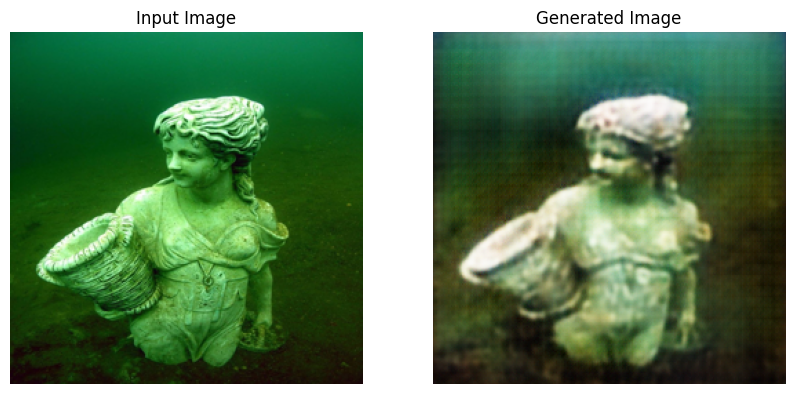

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model (assuming it’s saved as 'generator_final.pth')
generator = Generator().to(device)
generator.load_state_dict(torch.load('/content/drive/MyDrive/DIP_Project/Checkpoint_NormalGan/generator_final.pth'))
generator.eval()  # Set the model to evaluation mode

# Transform for preprocessing the image (same as during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load an image to test (make sure the image is in the correct path)
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/91_img_.png'  # Update the path to the image you want to test
image = Image.open(input_image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Generate the output
with torch.no_grad():
    output = generator(input_tensor)

# Convert the output tensor to a PIL image
output_image = output.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
output_image = np.clip(output_image * 255, 0, 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
output_pil = Image.fromarray(output_image)

# Save or display the result
output_pil.show()  # Show the output image using PIL

# Optionally, display the input image alongside the output
input_image = image.resize((256, 256))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis('off')
axes[1].imshow(output_pil)
axes[1].set_title("Generated Image")
axes[1].axis('off')
plt.show()

<ipython-input-14-89fe35d1be5f>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/drive/MyDrive/DIP_Project/Checkpoint_NormalGa

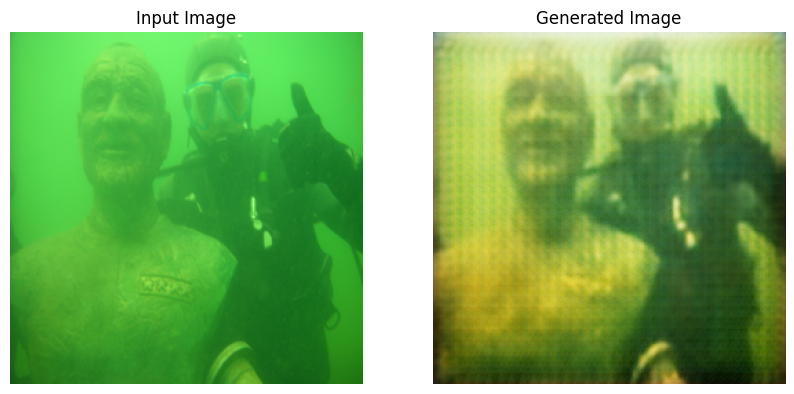

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model (assuming it’s saved as 'generator_final.pth')
generator = Generator().to(device)
generator.load_state_dict(torch.load('/content/drive/MyDrive/DIP_Project/Checkpoint_NormalGan/generator_final.pth'))
generator.eval()  # Set the model to evaluation mode

# Transform for preprocessing the image (same as during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load an image to test (make sure the image is in the correct path)
input_image_path = '/content/drive/MyDrive/DIP_Project/raw-890/906_img_.png'  # Update the path to the image you want to test
image = Image.open(input_image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Generate the output
with torch.no_grad():
    output = generator(input_tensor)

# Convert the output tensor to a PIL image
output_image = output.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
output_image = np.clip(output_image * 255, 0, 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
output_pil = Image.fromarray(output_image)

# Save or display the result
output_pil.show()  # Show the output image using PIL

# Optionally, display the input image alongside the output
input_image = image.resize((256, 256))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis('off')
axes[1].imshow(output_pil)
axes[1].set_title("Generated Image")
axes[1].axis('off')
plt.show()

In [ ]:
!pip install pytorch-msssim scipy
!pip install torch-fidelity

In [ ]:
!pip install torch-fidelity

In [ ]:
!pip install pytorch-fid

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.2 MB/s eta 0:00:00


In [ ]:
!pip install torch-fidelity
!pip install torchmetrics

In [ ]:
!pip install -U torchmetrics[image]

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics import MeanSquaredError, PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import cv2

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class for loading raw and reference images
class UIEB_Dataset(Dataset):
    def __init__(self, raw_dir, reference_dir, transform=None):
        self.raw_dir = raw_dir
        self.reference_dir = reference_dir
        raw_files = set(os.listdir(raw_dir))
        reference_files = set(os.listdir(reference_dir))
        self.image_names = sorted(raw_files.intersection(reference_files))
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        raw_image_path = os.path.join(self.raw_dir, self.image_names[idx])
        reference_image_path = os.path.join(self.reference_dir, self.image_names[idx])

        if not os.path.exists(reference_image_path):
            raise FileNotFoundError(f"Reference image not found: {reference_image_path}")

        raw_image = Image.open(raw_image_path).convert('RGB')
        reference_image = Image.open(reference_image_path).convert('RGB')

        if self.transform:
            raw_image = self.transform(raw_image)
            reference_image = self.transform(reference_image)

        return raw_image, reference_image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust this to match your model's input size
    transforms.ToTensor(),
])

# Directory paths
raw_dir = '/content/drive/MyDrive/DIP_Project/raw-890/'
reference_dir = '/content/drive/MyDrive/DIP_Project/reference-890/'

# Create the dataset and dataloader
dataset = UIEB_Dataset(raw_dir, reference_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Load the generator model
generator = Generator().to(device)
generator.load_state_dict(torch.load('/content/drive/MyDrive/DIP_Project/Checkpoint_NormalGan/generator_final.pth', map_location=device))
generator.eval()  # Set the model to evaluation mode

# Initialize metrics
mse = MeanSquaredError().to(device)
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)
fid = FrechetInceptionDistance().to(device)

# Function to convert image tensor for FID metric
def convert_to_uint8_for_fid(image_tensor):
    image_tensor = (image_tensor * 255).clamp(0, 255)  # Rescale from [0, 1] to [0, 255]
    return image_tensor.to(torch.uint8)

# Function to calculate UICM (Colorfulness)
def calculate_uicm(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab_image)
    colorfulness = np.sqrt(np.mean(A**2) + np.mean(B**2))
    return colorfulness

# Function to calculate UISM (Sharpness)
def calculate_uism(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sharpness = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return sharpness

# Function to calculate UIConM (Contrast)
def calculate_uiconm(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    contrast = gray_image.std()
    return contrast

# Function to calculate UIQM by combining UICM, UISM, and UIConM
def calculate_uiqm(image):
    uicm = calculate_uicm(image)
    uism = calculate_uism(image)
    uiconm = calculate_uiconm(image)
    uiqm = 0.5 * uicm + 0.3 * uism + 0.2 * uiconm
    return uiqm

# Function to process the image tensor and convert it to a numpy array
def tensor_to_numpy(image_tensor):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert from CxHxW to HxWxC
    image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Rescale to [0, 255] and convert to uint8
    return image

# Iterate through the dataloader
uiqm_scores = []

for batch in dataloader:
    raw_images, reference_images = batch
    raw_images, reference_images = raw_images.to(device), reference_images.to(device)

    # Generate images using the model
    with torch.no_grad():
        generated_images = generator(raw_images)

    # Scale from [-1, 1] to [0, 1] for MSE, PSNR, SSIM
    generated_images_scaled = (generated_images * 0.5 + 0.5)

    # Update metrics (MSE, PSNR, SSIM)
    mse.update(generated_images_scaled, reference_images)
    psnr.update(generated_images_scaled, reference_images)
    ssim.update(generated_images_scaled, reference_images)

    # Convert images for FID metric
    generated_images_uint8 = convert_to_uint8_for_fid(generated_images_scaled)
    reference_images_uint8 = convert_to_uint8_for_fid(reference_images)

    # Update FID metric
    fid.update(generated_images_uint8, real=False)
    fid.update(reference_images_uint8, real=True)

    # Calculate UIQM for each image in the batch
    for img in generated_images_scaled:
        img_numpy = tensor_to_numpy(img)  # Convert to numpy array
        uiqm_value = calculate_uiqm(img_numpy)  # Calculate UIQM
        uiqm_scores.append(uiqm_value)

# Compute final scores
mse_score = mse.compute().item()
psnr_score = psnr.compute().item()
ssim_score = ssim.compute().item()
fid_score = fid.compute().item()
uiqm_score = np.mean(uiqm_scores)  # Average UIQM across the batch

# Print results
print(f"MSE: {mse_score:.4f}")
print(f"PSNR: {psnr_score:.4f}")
print(f"SSIM: {ssim_score:.4f}")
print(f"FID: {fid_score:.4f}")
print(f"UIQM: {uiqm_score:.4f}")

<ipython-input-27-4d9c16056023>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('/content/drive/MyDrive/DIP_Project/Checkpoint_NormalG

MSE: 0.1024
PSNR: 9.8979
SSIM: 0.4894
FID: 59.7556
UIQM: 15.7579
